# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [35]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [36]:
train, test = keras.datasets.cifar10.load_data()

In [37]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [38]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [39]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [40]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [1e-1, 1e-3, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

In [41]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
## DAY76 
"""
RMSprop -> keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) 
AdaGrad -> keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
Adam -> keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0) 
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 6s 31ms/step - loss: 12235

196/196 [==============================] - 6s 31ms/step - loss: 2.3075 - accuracy: 0.1006 - val_loss: 2.3144 - val_accuracy: 0.1000
Experiment with LR = 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________

Epoch 50/50
196/196 [==============================] - 5s 27ms/step - loss: 0.7997 - accuracy: 0.7109 - val_loss: 1.9039 - val_accuracy: 0.4739
Experiment with LR = 0.000010
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__

196/196 [==============================] - 6s 28ms/step - loss: 1.4035 - accuracy: 0.5124 - val_loss: 1.4639 - val_accuracy: 0.4846
Epoch 50/50
196/196 [==============================] - 6s 29ms/step - loss: 1.3995 - accuracy: 0.5150 - val_loss: 1.4581 - val_accuracy: 0.4862


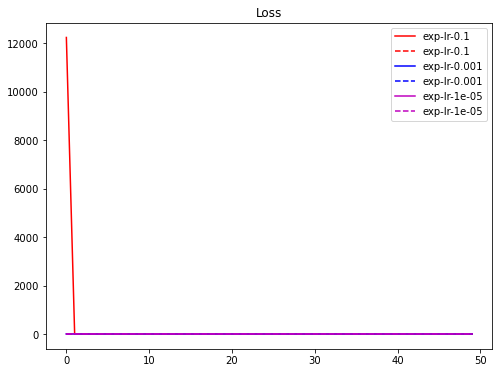

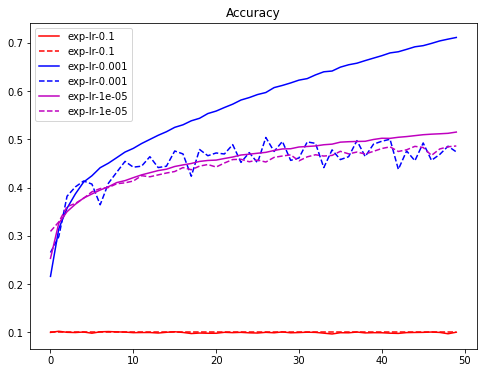

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "b", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [43]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
## DAY76 
"""
RMSprop -> keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) 
AdaGrad -> keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
Adam -> keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 4s 19ms/step - loss: 2.241

196/196 [==============================] - 4s 19ms/step - loss: 0.8140 - accuracy: 0.7078 - val_loss: 1.7581 - val_accuracy: 0.4892
Experiment with LR = 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________

Epoch 50/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5035 - accuracy: 0.4767 - val_loss: 1.5308 - val_accuracy: 0.4636
Experiment with LR = 0.000010
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
__

196/196 [==============================] - 4s 19ms/step - loss: 2.1676 - accuracy: 0.2359 - val_loss: 2.1657 - val_accuracy: 0.2424
Epoch 50/50
196/196 [==============================] - 4s 19ms/step - loss: 2.1656 - accuracy: 0.2366 - val_loss: 2.1637 - val_accuracy: 0.2427


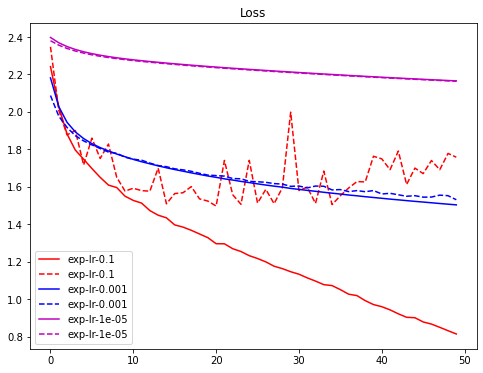

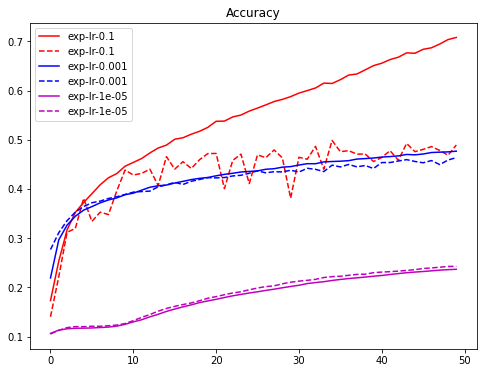

In [44]:

color_bar = ["r", "b", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [45]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
## DAY76 
"""
RMSprop -> keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) 
AdaGrad -> keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
Adam -> keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 4s 19ms/step - loss: 236.0

196/196 [==============================] - 4s 19ms/step - loss: 2.3070 - accuracy: 0.1005 - val_loss: 2.3066 - val_accuracy: 0.1000
Experiment with LR = 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________

196/196 [==============================] - 4s 19ms/step - loss: 0.6638 - accuracy: 0.7624 - val_loss: 1.7216 - val_accuracy: 0.5208
Epoch 50/50
196/196 [==============================] - 4s 19ms/step - loss: 0.6463 - accuracy: 0.7693 - val_loss: 1.7853 - val_accuracy: 0.5202
Experiment with LR = 0.000010
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dens

Epoch 49/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3554 - accuracy: 0.5309 - val_loss: 1.4275 - val_accuracy: 0.4951
Epoch 50/50
196/196 [==============================] - 4s 20ms/step - loss: 1.3499 - accuracy: 0.5344 - val_loss: 1.4244 - val_accuracy: 0.4991


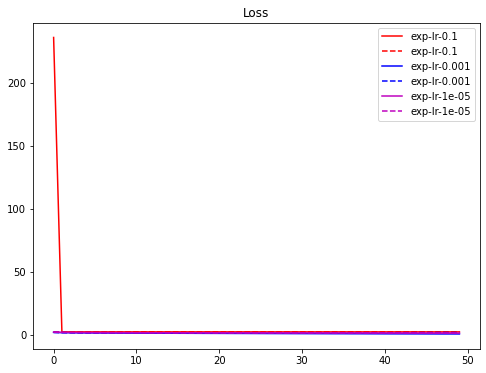

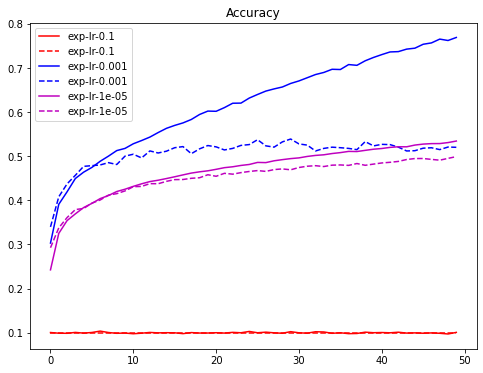

In [46]:

color_bar = ["r", "b", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()